In [1]:
# Imports
# turn off automated parallelization:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import emcee
import corner
from math import pi, isnan

In [2]:
# all the function definitions here

# here we test getting the parameters of a polynomial
def model(params, indep):
    a, b, c, d = params
    x = indep

    return(a * x**3 + b * x**2 + c * x + d)

# uniform PRIOR for emcee
def uniform_prior_for_emcee(params, bounds):
    for i, p in enumerate(params):
        if p < bounds[i][0]:
            return(-np.inf)
        if p > bounds[i][1]:
            return(-np.inf)
    return(0.0)

# neg. log. LIKELIHOOD for emcee
def log_likelihood_for_emcee(params, ind_vars, data, data_err=None, func=lambda x: x):
    ll = 0.0

        
    # get the synthetics for these parameters
    synth = function(params, *ind_vars)
    
    # data could be several dimensions
    data = np.array(data)
    if np.ndim(data) == 1:
        data = np.array(data, ndmin=2)
        if data_err is None:
            data_err = np.ones(data.shape)
        else:
            data_err = np.array(data_err, ndmin=2)

    for ixd, d in enumerate(data):

        sigma2 = data_err[ixd] ** 2
        res = synth - d
        # print(np.abs(res).max())
        ll += -0.5 * np.sum(res ** 2 / sigma2) - np.sum(np.log(np.sqrt(2. * pi * sigma2)))

    return ll


# neg. log. probability for emcee
def log_probability_for_emcee(params, ind_vars, bounds, data, cov, func):

    prior = uniform_prior_for_emcee(params, bounds)
    llh = log_likelihood_for_emcee(params, ind_vars, data, cov, func)
    #print("Prior, ", prior)
    #print("loglikelihood, ", llh)
    if not np.isfinite(prior):
        return(-np.inf)
    else:
        return(llh + prior)




# Fixed model parameters and starting values

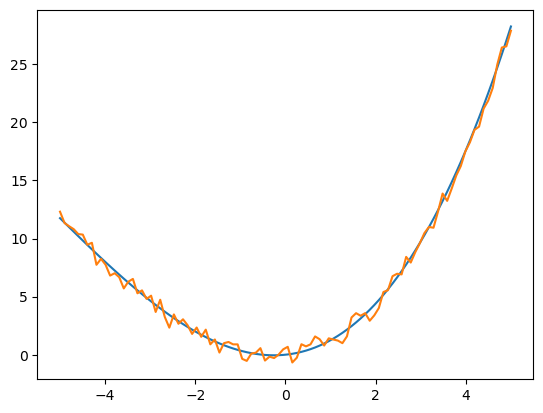

In [38]:
# inputs for the synthetic test :)
solution = [0.05, 0.8, 0.4, 0.0]
x = np.linspace(-5, 5, 100)
true = solution[0] * x**3 + solution[1] * x**2 + solution[2] * x + solution[3]
noise_amplitude = 0.5
noisy = true + np.random.randn(100) * noise_amplitude
plt.plot(x, true)
plt.plot(x, noisy)
output_dir = "synthetic_test_mcmc"


# function to model:
function = model

# initial guess:
x0 = [0, 0, 0, 0]

# diagonal of data covariance matrix:
error = np.ones(len(x)) * np.sqrt(noise_amplitude)

# for each parameter, specify lower and upper bound
bounds = [[-2, 2], [-2, 2], [-2, 2], [-1, 1]]
# chains to run
# INPUT
n_initializations = 12
n_multiprocess = 4
n_iterations = 10_000
n_burnin = 3000
max_iterations = 10_000


# independent variables:
independent_variables = [x]


In [39]:
# MCMC inversion to improve the fit
if not os.path.exists(output_dir):
    os.makedirs(output_dir)



# log_probability_for_emcee(params, ind_vars, bounds, data, cov)
# get the initial position from the max. likeligood model and perturb by small random nrs
print("initial values: ", x0)

# run the inversion
perturb_initial_values = np.random.randn(n_initializations, len(x0)) + 1.0
position = np.array([x0]*n_initializations) * perturb_initial_values + 0.01 * (perturb_initial_values - 1.)

nwalkers, ndim = (n_initializations, len(x0))

with multiprocessing.Pool(n_multiprocess) as pool:
    # Initialize the sampler
    # here you can edit the types of moves etc.
    ind_vars = independent_variables
    cov = error
    data = noisy
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_for_emcee,
                                    moves=[(emcee.moves.StretchMove(a=2.0), 0.5),
                                            (emcee.moves.DESnookerMove(), 0.5)],
                                    args=(ind_vars, bounds, data, cov, function),
                                    pool=pool)
    iterations_performed = 0
    have_tau = False
    while True:
        try:
            position = sampler.run_mcmc(position, n_iterations, progress=True, skip_initial_state_check=True)
            iterations_performed += n_iterations
        except ValueError:  # badly conditioned starting point
            position = sampler.get_last_sample()
            position.coords += np.random.randn(n_initializations, len(init_pos)) *\
                               np.array(init_perturbation[0: len(init_pos)])
        
        tau = sampler.get_autocorr_time(discard=n_burnin)
        print(tau)
        if not np.any(np.isnan(tau)):
            foname = output_dir + "/tau.txt"
            with open(foname, "w") as fh:
                for ttau in tau:
                    fh.write(f"{ttau}")
            thin = int(np.max(tau)) // 2
            print("Tau could be estimated, tau: ", np.max(tau))
            have_tau = True
            break
        else:
            if iterations_performed < max_iterations:
                print("Apparently no convergence yet, adding another {} samples.".format(n_iterations))
            else:
                print("No convergence despite performing maximum number of iterations. Giving up.")
                break

if not have_tau:
    thin = 2
    #continue


# get and save the samples
all_samples_temp = sampler.get_chain(discard=n_burnin)
# save the "clean" ensemble: Post burn-in, flat, decimated by 1/2 * autocorrelation time.
flat_samples = sampler.get_chain(flat=True, discard=n_burnin, thin=thin)
log_prob_samples = sampler.get_log_prob(discard=n_burnin, flat=True, thin=thin)


# Plot the chains
fig, axes = plt.subplots(ndim, figsize=(10, 2*ndim), sharex=True)
labels = ["a",  "b",  "c", "d", "e",]
for ixparam in range(ndim):
    ax = axes[ixparam]
    ax.plot(all_samples_temp[:, :, ixparam], "k", alpha=0.3)
    ax.set_xlim(0, len(all_samples_temp))
    ax.set_ylabel(labels[ixparam])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("Step number")
foname = (output_dir + "/MCMC_chains_{}{}.png".format("test_inversion", {True: "", False: "_noconvergence"}[have_tau]))
fig.savefig(foname)
plt.close()


# Create a corner plot and save
flat_samples = sampler.get_chain(flat=True, discard=n_burnin, thin=thin)
log_prob_samples = sampler.get_log_prob(discard=n_burnin, flat=True, thin=thin)
if flat_samples.shape[0] > 50:
    samples_probs = np.concatenate((flat_samples, log_prob_samples[:, None]), axis=1)
    print(samples_probs.shape)

    labels += ["log prob"]
    fig = corner.corner(
        samples_probs, labels=labels
    );
    foname = (output_dir + "/MCMC_{}{}.png".format("test_inversion", {True: "", False: "_noconvergence"}[have_tau]))
    fig.savefig(foname)
    plt.close()

initial values:  [0, 0, 0, 0]


100%|████████████████████████████████████| 10000/10000 [00:43<00:00, 228.12it/s]


[84.58265082 64.9060121  77.90917598 63.6631418 ]
Tau could be estimated, tau:  84.58265081501112
(1992, 5)


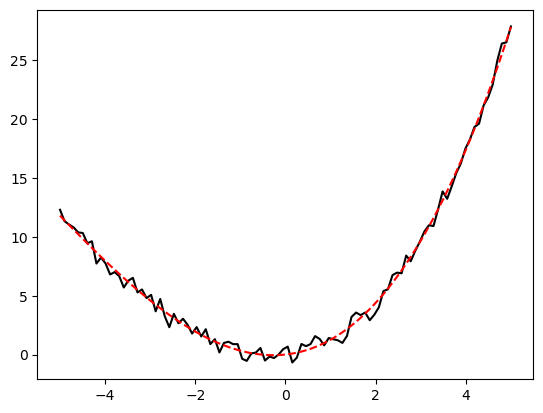

In [40]:

synth = function(np.median(flat_samples, axis=0), x)

plt.plot(x, noisy, "k")
plt.plot(x, synth, "r--")


In [41]:
print(np.median(flat_samples, axis=0))
print(np.mean(flat_samples, axis=0))
print(np.std(flat_samples, axis=0))
print(solution)

[0.04736441 0.79286523 0.42035617 0.00773237]
[0.0472851  0.79294867 0.42169802 0.00977528]
[0.00336276 0.00838253 0.05635047 0.09791642]
[0.05, 0.8, 0.4, 0.0]
